## Latent Space Exploration
In this notebook, we will explore the latent space of the CLIP model with our dataset. We will use the CLIP model to encode the images and captions into a 512-dimensional latent space. We will then use the t-SNE algorithm to reduce the dimensionality of the latent space to 2D and visualize the latent space.

In [7]:
import sys
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Adjust sys.path if needed
project_root = Path(os.getcwd()).parent
if str(project_root / 'src') not in sys.path:
    sys.path.append(str(project_root / 'src'))

from models.glip_loc import GLIPLocModel
from data.vigor_plus import VigorDataset
from torch.utils.data import DataLoader

In [8]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "convnext_base"  #  "convnext_base", "openai/clip-vit-base-patch32"
use_text = True

# Initialize model
model = GLIPLocModel(model_name=model_name, pretrained=True, use_text=use_text).to(device)
model.eval()


GLIPLocModel(
  (text_model): CLIPTextModelWithProjection(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_feat

In [32]:
from torchvision import transforms

ground_transforms = transforms.Compose([
    transforms.Resize((224, 224*2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

satellite_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_folder = "/home/erzurumlu.1/yunus/research_drive/data/VIGOR"  
dataset = VigorDataset(
    data_folder=data_folder,
    split='val',         # or 'val', depending on what you want to test
    same_area=False,        # set to False if you want to test cross-area splits
    ground_transforms=ground_transforms,
    satellite_transforms=satellite_transforms,
    use_captions=True
)

In [33]:
# Let's say we take N=5 samples
N = 150
embeddings = []
labels = []
sample_ids = []
roles = []  # "Ground Image", "Satellite Image", "Ground Text", "Satellite Text"


In [34]:
for i in range(N):
    ground_img, satellite_img, label, ground_cap, satellite_cap = dataset[i]
    ground_img = ground_img.unsqueeze(0).to(device)
    satellite_img = satellite_img.unsqueeze(0).to(device)
    ground_texts = [ground_cap]
    satellite_texts = [satellite_cap]

    with torch.no_grad():
        g_img_emb, s_img_emb, g_txt_emb, s_txt_emb = model(
            ground_image=ground_img,
            satellite_image=satellite_img,
            ground_captions=ground_texts,
            satellite_captions=satellite_texts
        )

    # Convert to numpy and store
    if g_img_emb is not None:
        embeddings.append(g_img_emb.squeeze(0).cpu().numpy())
        labels.append(f"Sample {i} - Ground Image")
        sample_ids.append(i)
        roles.append("Ground Image")

    if s_img_emb is not None:
        embeddings.append(s_img_emb.squeeze(0).cpu().numpy())
        labels.append(f"Sample {i} - Satellite Image")
        sample_ids.append(i)
        roles.append("Satellite Image")

    if g_txt_emb is not None:
        embeddings.append(g_txt_emb.squeeze(0).cpu().numpy())
        labels.append(f"Sample {i} - Ground Text")
        sample_ids.append(i)
        roles.append("Ground Text")

    if s_txt_emb is not None:
        embeddings.append(s_txt_emb.squeeze(0).cpu().numpy())
        labels.append(f"Sample {i} - Satellite Text")
        sample_ids.append(i)
        roles.append("Satellite Text")

In [35]:

embeddings = np.array(embeddings)

# Use a lower perplexity if N is small. For N=5 samples * 4 embeddings = 20 points.
# Perplexity ~ 5 might be okay. If error persists, reduce perplexity further.
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

# Create a DataFrame for Plotly
import pandas as pd
df = pd.DataFrame({
    'x': emb_2d[:,0],
    'y': emb_2d[:,1],
    'label': labels,
    'sample_id': sample_ids,
    'role': roles
})


In [36]:
import plotly.express as px

symbol_map = {
    "Ground Image": "circle",
    "Satellite Image": "square",
    "Ground Text": "diamond",
    "Satellite Text": "cross"
}

df['symbol'] = df['role'].map(symbol_map)

# Plotly express scatter
fig = px.scatter(
    df, x='x', y='y', 
    hover_name='label',
    color='sample_id',        # Color by sample_id
    symbol='symbol',          # Symbol by role
    labels={'sample_id': 'Sample ID'},
    title="t-SNE Visualization of Multiple Samples"
)

# Optional: Increase marker size
fig.update_traces(marker=dict(size=10))
fig.show()

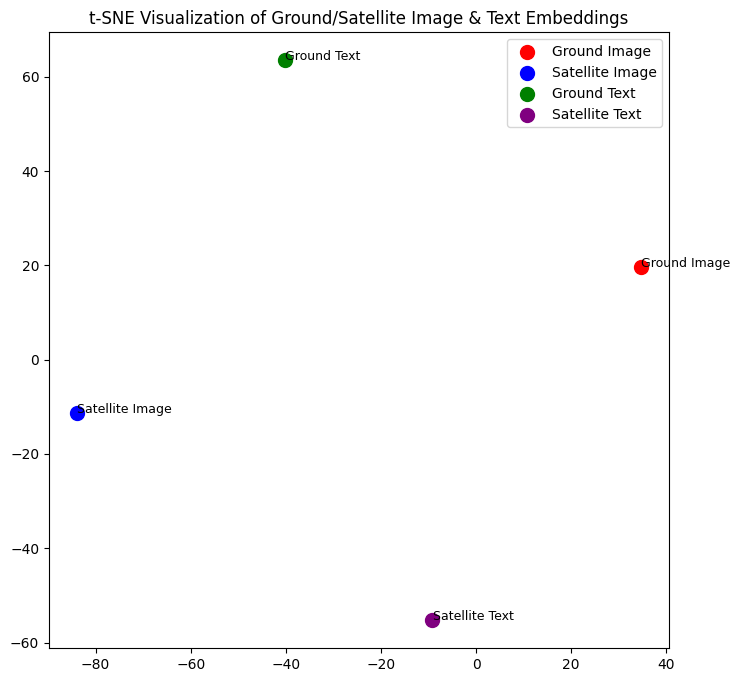

In [25]:
# Plot
plt.figure(figsize=(8,8))
colors = ['red', 'blue', 'green', 'purple']
for i, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y, c=colors[i], label=labels[i], s=100)
    plt.text(x+0.01, y+0.01, labels[i], fontsize=9)

plt.title("t-SNE Visualization of Ground/Satellite Image & Text Embeddings")
plt.legend()
plt.show()